Bending Beam PyMAPDL tutorial
=============================
First we need to launch an MAPDL instance calling launch_mapdl(). The return value is an object used
to access this instance via methods.

In [61]:
import numpy as np
from ansys.mapdl.core import launch_mapdl
from bending_beam import Beam, reset_mapdl, create_geometry_v1
mapdl = launch_mapdl()
print(mapdl)  # show ANSYS version and PyMAPDL version

Product:         ANSYS Academic Research
MAPDL Version:   RELEASE  Release 19.1      BUILD 19.1      UPDATE 20180418
PyMAPDL Version: 0.58.8



In [62]:
# clean up potential previous data inside MAPDL
mapdl.finish()
mapdl.clear()

Now we can define variables for the bending beam geometry and some kind of load.

In [63]:
# --------------------------------------------------------------------------
# ------------------------------ parameters --------------------------------
# --------------------------------------------------------------------------
# units SI [Pa, N, m, Nm]
E_beam = Beam.E  # 70e9
pr_beam = 0.0
length = 0.1
height = 0.02
depth = 0.01
M = 2000
F = 3000

et_num_beam = 1
mat_num_beam = 1
element_type_beam = "plane_182"  # more about element types later

Lets start to give commands to MAPDL. Fist we define an element type to use for the beam and set
material data E und PR (Poisson ratio).

In [64]:
mapdl.prep7()
mapdl.antype("static")
mapdl.et(itype=et_num_beam, ename=element_type_beam)
# mapdl.keyopt(1, 1, 3)  # IMPLIFIED ENHANCED STRAIN FORMULATION
mapdl.mp("ex", mat=mat_num_beam, c0=E_beam)
mapdl.mp("nuxy", mat_num_beam, c0=pr_beam);

Now it's time to create the geometry.

[1, 2, 3, 4, 5, 6]


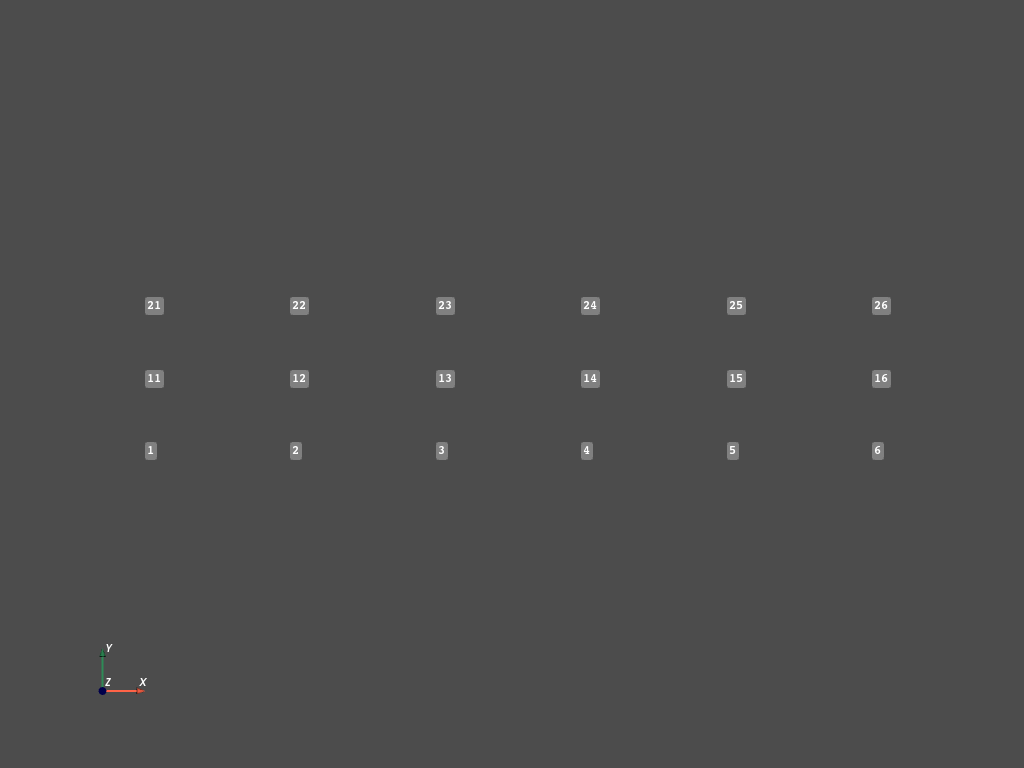

[(0.05, 0.01, 0.1970109854772478),
 (0.05, 0.01, 0.0),
 (0.0, 1.0, 0.0)]

In [65]:
beam_nodes_x = 6
beam_nodes_y = 2
nodes = []
for x in np.linspace(0, length, beam_nodes_x):
    nodes.append(mapdl.n(x=x))
print(nodes)
mapdl.ngen(3, 10, node1=nodes[0], node2=nodes[-1], ninc=1, dy=height*0.5)
mapdl.nplot(knum=True, cpos='xy')#, title ="asd")

In [66]:
e0 = mapdl.e(1, 2, 12, 11)
e1 = mapdl.e(11, 12, 22, 21)
mapdl.egen(5, ninc=1, iel1=e0, iel2=e1)
#mapdl.open_gui()

'GENERATE       5 TOTAL SETS OF ELEMENTS WITH NODE INCREMENT OF         1\n   SET IS SELECTED ELEMENTS IN RANGE         1 TO         2 IN STEPS OF       1\n\n MAXIMUM ELEMENT NUMBER=        10'

In [67]:
# VM16, CASE 1 - END MOMENT, ROARK, PAGE 106, NO. 9
mapdl.d(1, "all", nend=21, ninc=10)
# mapdl.f(6, "fx", 1000)
# mapdl.f(26, "fx", -1000)
mapdl.f(16, "mx", 2000)
mapdl.outpr("nsol", 1)
mapdl.outpr("esol", 1)
mapdl.finish()
mapdl.run("/solu")
mapdl.output("SCRATCH")
mapdl.solve()
mapdl.post1()
mapdl.set("last")
mapdl.graphics("power")
mapdl.eshape(scale=1)
mapdl.view(1, 1, 1, 1)
mapdl.output()
bend_stress1 = mapdl.result.nodal_stress(0)[1].max()
u1 = mapdl.get_value("node", 26, "u", "y")

mapdl.exit()
# FINI
# /SOLU
# /COM, VM16, CASE 2 - END LOAD, ROARK, PAGE 104, NO. 1
# F,6,FX,,,16,10
# F,6,FY,150,,16,10
# /OUT,SCRATCH
# SOLVE
# FINISH
# /POST1
# SET,LAST
# /GRAPHICS,POWER
# /ESHAPE,1
# /VIEW,1,1,1,1
# /OUT,
# *GET,U2,NODE,16,U,Y
# PLNSOL,S,X !BENDING STRESS
# *GET,BEND_STRESS2,PLNSOL,0,MAX
# *DIM,LABEL,CHAR,2,2
# *DIM,VALUE,,2,3
# *DIM,VALUE2,,2,3
# LABEL(1,1) = 'DEFL','BEND_STRESS'
# LABEL(1,2) = ' (in) ',' (psi) '
# *VFILL,VALUE(1,1),DATA,.00500,3000
# *VFILL,VALUE(1,2),DATA,U1,BEND_STRESS1
# *VFILL,VALUE(1,3),DATA,ABS(U1/.005),ABS(BEND_STRESS1/3000)
# SAVE,TABLE_3
# *VFILL,VALUE2(1,1),DATA,.00500,4050
# *VFILL,VALUE2(1,2),DATA,U2,BEND_STRESS2
# *VFILL,VALUE2(1,3),DATA,ABS(U2/.005),ABS(BEND_STRESS2/4050)
# SAVE,TABLE_4

EAnsysUnknown: AAS_CORBA.MAPDL.Exceptions.EAnsysUnknown(code=-15, description='Low-level communication error -15: Connection was closed', scope='MAPDL', interfaceName='ICoMapdlUnit', operation='executeCommand', moreInfo='SOLVE,')